In [13]:
import pandas as pd
import logging
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pyro
import torch
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

X = np.asarray(
#[,1]        [,2]
    [[1.3709584,  1.48475156],
    [-0.5646982, -1.42449894],
    [0.3631284,  0.10432308],
    [0.6328626,  0.27923186],
    [0.4042683,  0.09138635],
    [-0.1061245 ,-0.53519391]]
)
Y = np.asarray([-1.46778013, -0.09421285, -0.41162052, -0.31177232, -0.52569912, -1.22375575]).reshape((6,))
X = torch.from_numpy(X).to(dtype=torch.float32)
Y = torch.from_numpy(Y).to(dtype=torch.float32)
X.shape, Y.shape

(torch.Size([6, 2]), torch.Size([6]))

### Multivariate Normal the Eventshape

The parameter $w$ is a [2,1] dimensional vector, it comes from a multivariate normal distribution. This has the event shape 2.

In [14]:
d = dist.MultivariateNormal(torch.tensor([0.,0]), torch.eye(2))
print(d.batch_shape, d.event_shape)
print(d.sample([1]))
pyro.sample("w", d)

torch.Size([]) torch.Size([2])
tensor([[0.8223, 0.1145]])


tensor([-1.0033,  0.6258])

#### Assuming independed slope
If I would assume independ slopes, a single draw should still have the eventshape of [2]

The eventshape corresponds to independent draws

In [15]:
d = dist.Normal(torch.tensor([0.,0]), torch.tensor([1,1]))
d.event_shape, d.batch_shape #[], 2
d = d.to_event(1)
d.event_shape, d.batch_shape #[2], []

(torch.Size([2]), torch.Size([]))

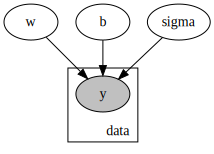

In [16]:
def model(X, Y=None):
    #w = pyro.sample("w", dist.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.eye(2)))
    # This would assume independend slopes
    w = pyro.sample("w", dist.Normal(torch.tensor([0.,0]), torch.tensor([1,1])).to_event(1))
    b = pyro.sample("b", dist.Normal(0., 10.))
    sigma = pyro.sample("sigma", dist.LogNormal(0.5, 1.))
    with pyro.plate("data"):
        mui = X@w + b
        # pyro.sample with "obs" is an observed random variable
        return pyro.sample("y", dist.Normal(mui, sigma), obs=Y)  # likelihood

pyro.render_model(model, model_args=(X,Y))

In [17]:
N2D = dist.Normal(torch.tensor([[0.],[0.]]), 10.)
w = pyro.sample("w", N2D)# prior distribution
N2D.event_shape

torch.Size([])

In [18]:
model(X)[0:2,],model(X)[0:2,],model(X,Y)[0:2,]

(tensor([8.0041, 9.3147]),
 tensor([-8.8470, 10.8754]),
 tensor([-1.4678, -0.0942]))

In [19]:
model(X,Y).shape, model(X).shape

(torch.Size([6]), torch.Size([6]))

### MCMC

In [20]:
from pyro.infer import NUTS, MCMC
conditioned_model = pyro.condition(model, data={"y": Y})
nuts_kernel = NUTS(conditioned_model, jit_compile=False)
mcmc = MCMC(nuts_kernel,
            num_samples=10,
            num_chains=1,
            warmup_steps=20)

mcmc.run(X,Y)

Sample: 100%|██████████| 30/30 [00:00, 59.36it/s, step size=4.74e-01, acc. prob=0.492]


In [21]:
mcmc.diagnostics()

{'b': OrderedDict([('n_eff', tensor(5.1047)), ('r_hat', tensor(1.2171))]),
 'sigma': OrderedDict([('n_eff', tensor(5.4926)), ('r_hat', tensor(1.1460))]),
 'w': OrderedDict([('n_eff', tensor([5.0087, 6.2977])),
              ('r_hat', tensor([1.4486, 0.8949]))]),
 'divergences': {'chain 0': []},
 'acceptance rate': {'chain 0': 0.9}}

### VI

In [22]:
#import pyro.poutine as poutine
#from pyro.infer import Trace_ELBO


In [23]:
# We'll ue this helper to check our models are correct.
# def test_model(model, guide, loss):
#    pyro.clear_param_store()
#    loss.loss(model(X), guide)

In [24]:
#test_model(model, guide(Trace_ELBO()))

In [25]:
#trace = poutine.trace(model).get_trace(X, Y)
#trace.compute_log_prob()
#print(trace.format_shapes())

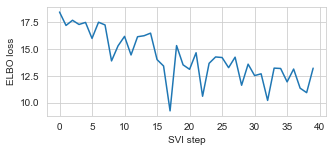

In [26]:
guide = pyro.infer.autoguide.AutoNormal(model)
pyro.clear_param_store() #Delete all existing parameters
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

losses = []
for step in range(40):  # Consider running for more steps.
    loss = svi.step(X,Y)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");